In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import optim
import syndata
import align
import mgplvm
from mgplvm import kernels, rdist, models, training
from mgplvm.manifolds import Torus
plt.rcParams.update({'font.size': 22})

In [2]:
torch.set_default_dtype(torch.float64)
device = mgplvm.utils.get_device("cuda")  # get_device("cpu")

d = 1  # dims of latent space
n = 50 # number of neurons
m = 100  # number of conditions / time points
n_z = 15  # number of inducing points
n_samples = 1  # number of samples
gen = syndata.Gen(syndata.Torus(d), n, m, variability=0.25, sigma = 0.3)

sig0 = 1.5
l = 0.6
gen.set_param('l', l)
Y = gen.gen_data()
print('mean activity:', np.mean(Y))
# specify manifold, kernel and rdist
manif = Torus(m, d)
ref_dist = mgplvm.rdist.MVN(m, d, sigma=sig0)
# initialize signal variance
alpha = np.mean(np.std(Y, axis=1), axis=1)
kernel = kernels.Linear(n, manif.linear_distance, alpha=alpha)
# generate model
sigma = np.mean(np.std(Y, axis=1), axis=1)  # initialize noise
likelihoods = mgplvm.likelihoods.Gaussian(n, variance=np.square(sigma))
mod = models.Svgp(manif, n, m, n_z, kernel, likelihoods, ref_dist, whiten=True).to(device)

mean activity: 0.4140505714336249


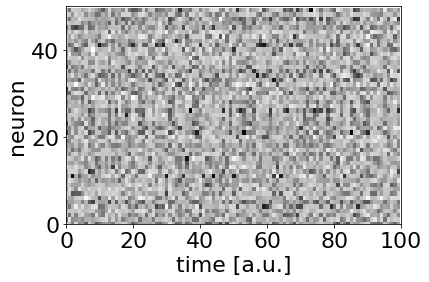

In [3]:
plt.figure()
Yplot = Y[:, :, 0]
plt.imshow(Yplot, cmap='Greys', aspect='auto')
plt.xlabel("time [a.u.]")
plt.ylabel("neuron")
plt.xlim(0,100)
plt.ylim(0,n)
plt.show()
plt.close()

In [4]:
# train model
trained_mod = training.svgp(Y, 
                           mod, 
                           device, 
                           optimizer=optim.Adam, 
                           outdir='none', 
                           max_steps=500, 
                           burnin=150, 
                           n_mc=64, 
                           lrate=5E-2, 
                           print_every=50)

data = torch.tensor(Y, dtype=torch.get_default_dtype()).to(device)
mod = mod.to(device)
mulearn = mod.manif.prms.data.cpu()
mutrue = gen.gs[0]
plearn = mod.manif.distance(mulearn.T, mulearn.T).numpy()
ptrue = gen.manifold.manifs[0].distance(mutrue, mutrue)
ptrue, plearn = [p.flatten() for p in [ptrue, plearn]]

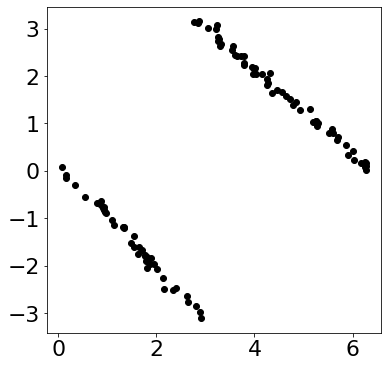

In [5]:
gs_true = gen.gs[0]
gprefs_true = gen.gprefs[0]
g_mus = mod.manif.prms.data.cpu().numpy()[:]
plt.figure(figsize=(6,6))
plt.plot(gs_true[:, 0], g_mus[:, 0], "ko")
plt.show()
plt.close()

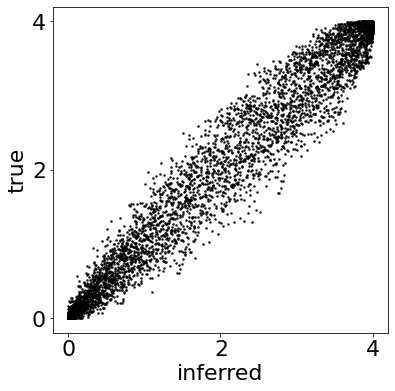

In [6]:
plt.figure(figsize=(6, 6))
plt.plot(plearn, ptrue, "ko", markersize=1.5, alpha=0.5)
plt.xlabel("inferred")
plt.ylabel("true")
plt.xticks((0, 2, 4), ("$0$", "$2$", "$4$"))
plt.yticks((0, 2, 4), ("$0$", "$2$", "$4$"))
plt.show()
plt.close()